In [1]:
import sys
from collections import defaultdict
import xlrd
import gurobipy as grb
from gurobipy import GRB

import numpy as np
import math

In [2]:
class Hotspot():
    def __init__(self, number, profits, area, uuv_obs_rate):
        self.number = number
        self.profits = profits
        self.area = area
        self.lam = uuv_obs_rate/area

In [3]:
np.random.seed(248745)
distance = np.random.randint(0, 10000, size=(7,7))
with open('./../santa_monica_energy_costs.npy', 'rb') as f:
    transit_times = np.load(f)
distance[1:, 1:] = transit_times[:,:,0]
distance[0,0] = 99999999
print (distance)

[[99999999     6436     1189     1817     8262      805     3080]
 [    7599 99999999        0        0     1609        0        0]
 [    1006     9401 99999999     7167    11017     7737     4803]
 [    6739     2202        0 99999999     3783      640        0]
 [    3120        0        0        0 99999999        0        0]
 [    2709     1625        0        0     3260 99999999        0]
 [    9523     4483        0     2234     6099     2879 99999999]]


In [22]:
# distance = np.random.randint(0, 1000, size=(7,7))

##build all the hotspot data
uuv_obs_rate = (5**2)*math.pi #arbitrarily selected observation rate
all_hotspots = [Hotspot(0, 0, 99999999, uuv_obs_rate), ##This is the init position
                Hotspot(1, np.random.randint(0,100), np.random.randint(500,2500), uuv_obs_rate),
                Hotspot(2, np.random.randint(0,100), np.random.randint(500,2500), uuv_obs_rate),
                Hotspot(3, np.random.randint(0,100), np.random.randint(500,2500), uuv_obs_rate),
                Hotspot(4, np.random.randint(0,100), np.random.randint(500,2500), uuv_obs_rate),
                Hotspot(5, np.random.randint(0,100), np.random.randint(500,2500), uuv_obs_rate),
                Hotspot(6, np.random.randint(0,100), np.random.randint(500,2500), uuv_obs_rate),
                ]

In [23]:
hotspot_idx = [i.number for i in all_hotspots]
points = [(i,j) for i in hotspot_idx for j in hotspot_idx]
max_reward = [i.profits for i in all_hotspots]
area = [i.area for i in all_hotspots]
lam = [i.lam for i in all_hotspots]
# Distance = 50000
Distance = 3000
n = len(all_hotspots)

In [24]:
print(lam)
print(area)
print (uuv_obs_rate)
print (max_reward)

print (uuv_obs_rate/area[1])

[7.8539817125143e-07, 0.12526286497566957, 0.06865368561166506, 0.04031818087255895, 0.03729336008534892, 0.04472654689051528, 0.046694302223391694]
[99999999, 627, 1144, 1948, 2106, 1756, 1682]
78.53981633974483
[0, 55, 30, 47, 72, 99, 10]
0.12526286497566957


In [25]:
def profit(idx, h_time):
    return (1 - math.exp(-lam[idx] * h_time))*max_reward[idx]

In [28]:
opt_model = grb.Model(name="MILP Model")

# <= Variables
##x_vars = x_ij travel from hotspot i to j
x_vars = {}
for i in range(n):
   for j in range(n):
     x_vars[i,j] = opt_model.addVar(vtype=grb.GRB.BINARY,
                          name='e'+str(i)+'_'+str(j))

##u = boolean if visit hotspot i
u={}
for i in range(1,n):
    u[i]=opt_model.addVar(vtype=grb.GRB.INTEGER,
                          name='e'+str(i))
    
##Introduce hotspot_time variable
##Create profits function
npts = 300
ptf = np.empty((n, npts))
ptu = np.arange(0, npts, 1).tolist()

for i in range(n):
    for p in range(npts):
        ptf[i,p] = profit(i, ptu[p])

t={}
for i in range(n):
    t[i] = opt_model.addVar(lb = 0.0, ub = 300, name='t'+str(i))
    opt_model.setPWLObj(t[i], ptu, ptf[i,:].tolist())
    
# <= Constraint (Mandatory Edges and excluding vertexes) Eq(1)
opt_model.addConstr(grb.quicksum([x_vars[1,j] for j in range(1,n)])  == 1)
opt_model.addConstr(grb.quicksum([x_vars[i,n-1] for i in range(n-1)])  == 1)
# opt_model.addConstr((grb.quicksum(x_vars[i,i] for i in range(n-1)))  == 0)


# <= Constraint (Distance) Eq(3)
# for i in range(n-1):
#   opt_model.addConstr(grb.quicksum([x_vars[i,j]*distance(points, i, j) for j in range(1,n)]) <= Distance)
# opt_model.addConstr(grb.quicksum([x_vars[i,j]*distance(points, i,j) for j in range(1,n) for i in range(n-1)]) <= Distance)
opt_model.addConstr(grb.quicksum([x_vars[i,j]*t[j]
                                + x_vars[i,j]*distance[i,j] for j in range(1,n) for i in range(n-1)]) <= Distance)

# <= Constraint (Equality & Single edge in and out) Eq(2)
for k in range(1, n-1):
#   opt_model.addConstr(grb.quicksum(x_vars[i,k] for i in range(n-1))
#                       == grb.quicksum(x_vars[k,j] for j in range(1, n)) <=1)

    one = grb.quicksum([x_vars[i,k] for i in range(n-1)])
    two = grb.quicksum([x_vars[k,j] for j in range(1, n)])
    opt_model.addConstr(one == two)
    opt_model.addConstr(one <= 1)

# <= Constraint (Subtour elimination) Eq(4) Eq(5)
for i in range(1,n):
    opt_model.addConstr(2 <= u[i])
    opt_model.addConstr(u[i] <= n)
#   opt_model.addConstr(2 <= u[i] <= n)

for i in range(1,n):
    for j in range(1,n):
        opt_model.addConstr((u[i] - u[j] +1 <= (n-1)*(1-x_vars[j,i])))

        
# <= objective (maximize) Eq(1)
objective = grb.quicksum([x_vars[i,j]*t[j] + x_vars[i,j]*distance[i,j]
                         for i in range(1, n-1)
                         for j in range(1, n)])

opt_model.ModelSense = grb.GRB.MAXIMIZE
opt_model.setObjective(objective)
opt_model.optimize()

solution = opt_model.getAttr('x', x_vars )
print (solution)

for v in opt_model.getVars():
    print('%s %g' % (v.VarName, v.X))

select = grb.tuplelist((i,j) for i,j in x_vars.keys() if x_vars[i,j].X > 0.5)
print (select)

total = 0
for z in range(len(select)):
    total += distance[select[z][0], select[z][1]] + profits[select[z][0]]
    
print ("TOTAL ANSWER IS : ", total)

##now do the second optimization trick   
# for i in range(0,n):
#     for p in range(npts):
#         ptf[i,p] = -ptf[i,p]
        
# t={}
# for i in range(1,n):
#     t[i]=opt_model.addVar(lb = 0.0, ub = 300, name="ti")
#     opt_model.setPWLObj(t[i], ptu, ptf[i,:].tolist())
    
# opt_model.optimize()


# # opt_model.update()
# # opt_model.computeIIS()
# # opt_model.write("model.ilp")
# solution = opt_model.getAttr('x', x_vars )

# print (solution)

# select = grb.tuplelist((i,j) for i,j in x_vars.keys() if x_vars[i,j].X > 0.5)
# print (select)

# total = 0
# for z in range(len(select)):
#     total += distance[select[z][0], select[z][1]] + profits[select[z][0]]
    
# print ("TOTAL ANSWER IS : ", total)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 60 rows, 62 columns and 200 nonzeros
Model fingerprint: 0xb85fb511
Model has 30 quadratic objective terms
Model has 1 quadratic constraint
Variable types: 7 continuous, 55 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [6e+02, 1e+08]
  Objective range  [6e+02, 1e+08]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 7e+00]
  QRHS range       [3e+03, 3e+03]
Presolve removed 60 rows and 58 columns
Presolve time: 0.00s
Presolved: 4 rows, 5 columns, 10 nonzeros
Variable types: 4 continuous, 1 integer (1 binary)
Found heuristic solution: objective 1625.0000000
Found heuristic solution: objective 1895.0000000

Root relaxation: objective -2.195000e+03, 0 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

NameError: name 'profits' is not defined

In [97]:
opt_model = grb.Model(name="MILP Model")

# <= Variables
##x_vars = x_ij travel from hotspot i to j
x_vars = {}
for i in range(n):
   for j in range(n):
     x_vars[i,j] = opt_model.addVar(vtype=grb.GRB.BINARY,
                          name='e'+str(i)+'_'+str(j))

##u = boolean if visit hotspot i
u={}
for i in range(1,n):
    u[i]=opt_model.addVar(vtype=grb.GRB.INTEGER,
                          name='e'+str(i))
    
##Introduce hotspot_time variable
##Create profits function
npts = 300
ptf = np.empty((n, npts))
ptu = np.arange(0, npts, 1).tolist()

for i in range(0,n):
    for p in range(npts):
        ptf[i,p] = profit(i, ptu[p])

t={}
r={}
for i in range(1,n):
    t[i] = opt_model.addVar(lb = 0.0, ub = 300, name='t'+str(i))
    r[i] = opt_model.addVar(lb = 0.0, name='r'+str(i))
    opt_model.addGenConstrPWL(t[i], r[i], ptu, ptf[i,:], "reward"+str(i))
#     opt_model.setPWLObj(t[i], ptu, ptf[i,:].tolist())
    
# r={}
# for i in range(1,n):
#     r[i] = opt_model.addVar(lb = 0.0, name='r'+str(i))
#     opt_model.addGenConstrPWL(r[i], ptu, i, ptf[i,:])
    
# <= Constraint (Mandatory Edges and excluding vertexes) Eq(1)
opt_model.addConstr(grb.quicksum([x_vars[1,j] for j in range(1,n)])  == 1)
opt_model.addConstr(grb.quicksum([x_vars[i,n-1] for i in range(n-1)])  == 1)

# <= Constraint (Distance) Eq(3)
opt_model.addConstr(grb.quicksum([x_vars[i,j]*t[j]
                                + x_vars[i,j]*distance[i,j] for j in range(1,n) for i in range(n-1)]) <= Distance)

# <= Constraint (Equality & Single edge in and out) Eq(2)
for k in range(1, n-1):
    one = grb.quicksum([x_vars[i,k] for i in range(n-1)])
    two = grb.quicksum([x_vars[k,j] for j in range(1, n)])
    opt_model.addConstr(one == two)
    opt_model.addConstr(one <= 1)

# <= Constraint (Subtour elimination) Eq(4) Eq(5)
for i in range(1,n):
    opt_model.addConstr(2 <= u[i])
    opt_model.addConstr(u[i] <= n)
    
for i in range(1,n):
    for j in range(1,n):
        opt_model.addConstr((u[i] - u[j] +1 <= (n-1)*(1-x_vars[j,i])))

        
# <= objective (maximize) Eq(1)
objective = grb.quicksum([x_vars[i,j]*r[j]
                         for i in range(1, n-1)
                         for j in range(1, n)])

opt_model.ModelSense = grb.GRB.MAXIMIZE
opt_model.setObjective(objective)
opt_model.optimize()

solution = opt_model.getAttr('x', x_vars )
print (solution)

# for v in opt_model.getVars():
#     print('%s %g' % (v.VarName, v.X))

select = grb.tuplelist((i,j) for i,j in x_vars.keys() if x_vars[i,j].X > 0.5)
givemetime = grb.tuplelist((i, t[i].X) for i in t.keys() if t[i].X > 0.0)
givemereward = grb.tuplelist((i, r[i].X) for i in r.keys() if r[i].X > 0.0)
print (select)
print (givemetime)
print (givemereward)

total_time = 0
total_profit = 0
for z in range(len(select)):
    print ("path len: ", distance[select[z][0], select[z][1]])
    print ("hotspot time: ", givemetime[z][1])
    total_time += distance[select[z][0], select[z][1]]
    total_time += givemetime[z][1]
    
for z in range(len(givemereward)):
    print ("hotspot reward: ", profit(givemereward[z][0], givemetime[z][1]))
    total_profit += profit(givemereward[z][0], givemetime[z][1])
    

print ("TOTAL ANSWER IS : ", total_time)
print ("TOTAL PROFIT IS: ", total_profit)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 60 rows, 67 columns and 200 nonzeros
Model fingerprint: 0x4d241c9f
Model has 30 quadratic objective terms
Model has 1 quadratic constraint
Model has 6 general constraints
Variable types: 12 continuous, 55 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [6e+02, 1e+08]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [1e+00, 7e+00]
  QRHS range       [3e+03, 3e+03]
Presolve added 0 rows and 1459 columns
Presolve removed 26 rows and 0 columns
Presolve time: 0.01s
Presolved: 66 rows, 1567 columns, 4660 nonzeros
Presolved model has 25 SOS constraint(s)
Variable types: 1541 continuous, 26 integer (22 binary)
Found heuristic solution: objective 13.0799524

Root relaxation: unbounded, 0 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bo

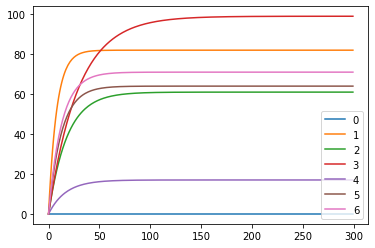

In [16]:
import matplotlib.pyplot as plt

x = np.arange(0, 300)
fig = plt.plot()
for i in range(len(all_hotspots)):
    y = (1 - np.exp(-lam[i] * x)) * max_reward[i]
    plt.plot(x, y, label=i)
plt.legend()
plt.show()

In [50]:
t.keys()

dict_keys([1, 2, 3, 4, 5, 6])

In [33]:
select

<gurobi.tuplelist (3 tuples, 2 values each):
 ( 0 , 5 )
 ( 1 , 6 )
 ( 5 , 1 )
>

In [38]:
opt_model.getVars()[0]

<gurobi.Var e0_0 (value 0.0)>

In [55]:
select[0]

(0, 5)

In [59]:
profit(select[0][1], givemetime[0][1])

98.99971182597697

In [58]:
givemetime[0]

(1, 285.0)

In [67]:
ptf[1, 285]

54.99999999999998